# Human Activity Recognition

<br>


This project is to build a model that predicts the human activities such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing or Laying.

This dataset is collected from 30 persons(referred as subjects in this dataset), performing different activities with a smartphone to their waists. The data is recorded with the help of sensors (accelerometer and Gyroscope) in that smartphone. This experiment was video recorded to label the data manually.

* Data source :-https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

## How data was recorded

By using the sensors(Gyroscope and accelerometer) in a smartphone, they have captured '3-axial linear acceleration'(_tAcc-XYZ_) from accelerometer and '3-axial angular velocity' (_tGyro-XYZ_) from Gyroscope with several variations. 

> prefix 't' in those metrics denotes time.

> suffix 'XYZ' represents 3-axial signals in X , Y, and Z directions.\


## Train and test data were saperated
 - The readings from ___70%___ of the volunteers were taken as ___trianing data___ and remaining ___30%___ subjects recordings were taken for ___test data___


In [1]:
# Importing Libraries

In [22]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
import tensorflow as tf
from matplotlib import pyplot
np.random.seed(42)

tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 64

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


## (A) 2 layer with dropout rate 0.8

- Defining the Architecture of LSTM

In [51]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.3340 - acc: 0.4357 - val_loss: 1.2770 - val_acc: 0.4164
Epoch 2/30
7352/7352 [==============================] - 33s 4ms/step - loss: 1.1464 - acc: 0.5076 - val_loss: 1.1079 - val_acc: 0.5443
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9714 - acc: 0.5896 - val_loss: 0.9413 - val_acc: 0.5996
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.8558 - acc: 0.6141 - val_loss: 1.0917 - val_acc: 0.5171
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.8323 - acc: 0.6224 - val_loss: 0.8586 - val_acc: 0.5962
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7773 - acc: 0.6428 - val_loss: 0.9042 - val_acc: 0.6037
Epoch 7/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7528 - acc: 0.6491 - val_loss: 0.9550 - val_acc: 0.6030
Epoch 8

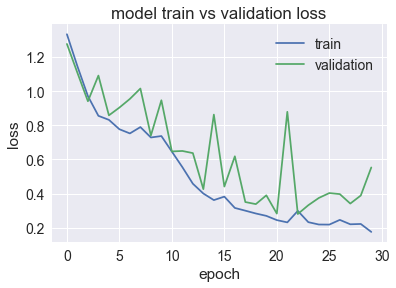

In [53]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

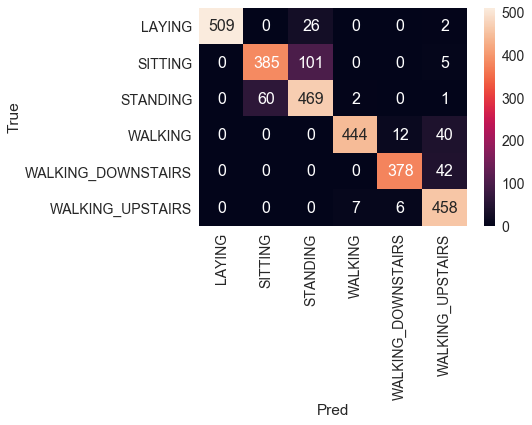

In [54]:
# Confusion Matrix
#print(confusion_matrix(Y_test, model.predict(X_test)))

confusion = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

In [55]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 1ms/step


In [56]:
score

[0.5532151480927816, 0.8968442483881914]

- With a simple 2 layer architecture we got 89.68% accuracy and a loss of 0.55
- We can further imporve the performace with Hyperparameter tuning

## (B) 2 layer with dropout rate 0.7

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.2472 - acc: 0.4629 - val_loss: 1.2637 - val_acc: 0.4445
Epoch 2/30
7352/7352 [==============================] - 33s 4ms/step - loss: 1.0554 - acc: 0.5482 - val_loss: 1.0001 - val_acc: 0.5606
Epoch 3/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.8615 - acc: 0.6224 - val_loss: 0.9072 - val_acc: 0.6200
Epoch 4/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.8186 - acc: 0.6579 - val_loss: 0.8627 - val_acc: 0.6756
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7427 - acc: 0.7031 - val_loss: 0.9022 - val_acc: 0.6773
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7393 - acc: 0.7078 - val_loss: 0.8770 - val_acc: 0.6576
Epoch 7/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.6600 - acc: 0.7352 - val_loss: 0.8023 - val_acc: 0.7078
Epoch 8

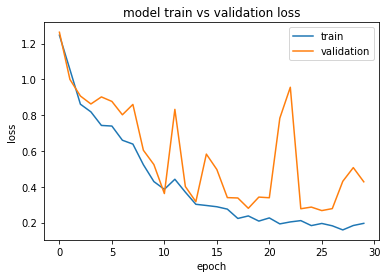

In [20]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

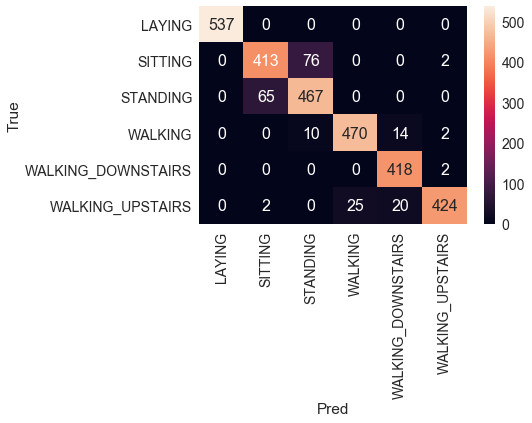

In [23]:
# Confusion Matrix
#print(confusion_matrix(Y_test, model.predict(X_test)))

confusion = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

In [24]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 487us/step


In [25]:
score

[0.42758658551398804, 0.9260264675941635]

## (C) 2 layer with dropout rate 0.5

- Defining the Architecture of LSTM

In [26]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 26s 4ms/step - loss: 1.4364 - acc: 0.3526 - val_loss: 1.3697 - val_acc: 0.3797
Epoch 2/30
7352/7352 [==============================] - 25s 3ms/step - loss: 1.0705 - acc: 0.5405 - val_loss: 0.9452 - val_acc: 0.5816
Epoch 3/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.9877 - acc: 0.5724 - val_loss: 0.9476 - val_acc: 0.5643
Epoch 4/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.8164 - acc: 0.6187 - val_loss: 0.8402 - val_acc: 0.6006
Epoch 5/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.7219 - acc: 0.6498 - val_loss: 0.7325 - val_acc: 0.6186
Epoch 6/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.6677 - acc: 0.6910 - val_loss: 0.8990 - val_acc: 0.6138
Epoch 7/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.6811 - acc: 0.7193 - val_loss: 0.6352 - val_acc: 0.7319
Epoch 8

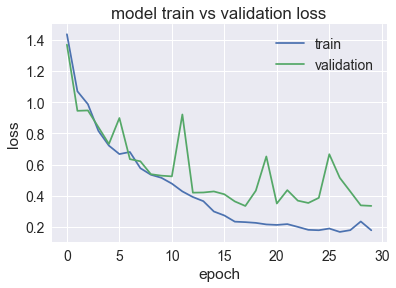

In [28]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

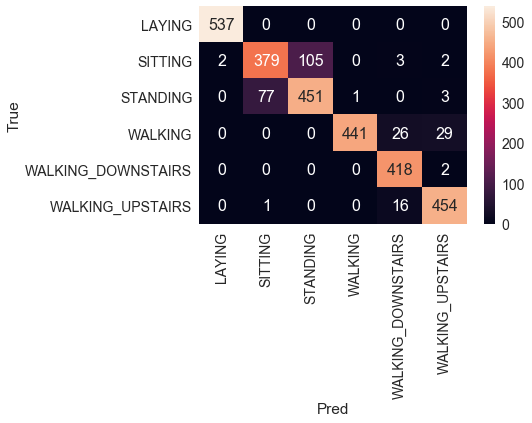

In [29]:
# Confusion Matrix
#print(confusion_matrix(Y_test, model.predict(X_test)))

confusion = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

In [30]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 331us/step


In [31]:
score

[0.3352397249300588, 0.9093993892093655]

## (A) 3  layer with dropout rate 0.8.

In [32]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 64

- Defining the Architecture of LSTM

In [33]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(LSTM(32)) 
# Adding a dropout layer
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 61s 8ms/step - loss: 1.3778 - acc: 0.4510 - val_loss: 1.2208 - val_acc: 0.5005
Epoch 2/30
7352/7352 [==============================] - 58s 8ms/step - loss: 1.0764 - acc: 0.5736 - val_loss: 0.8800 - val_acc: 0.7011
Epoch 3/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.9621 - acc: 0.6246 - val_loss: 0.7530 - val_acc: 0.7211
Epoch 4/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.8379 - acc: 0.6616 - val_loss: 0.6478 - val_acc: 0.7414
Epoch 5/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.7886 - acc: 0.6895 - val_loss: 0.6650 - val_acc: 0.7343
Epoch 6/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.6926 - acc: 0.7282 - val_loss: 0.5373 - val_acc: 0.8290
Epoch 7/30
7352/7352 [==============================] - 57s 8ms/step - loss: 0.6576 - acc: 0.7477 - val_loss: 0.6405 - val_acc: 0.8426
Epoch 8

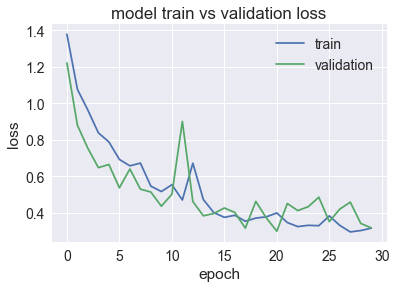

In [35]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

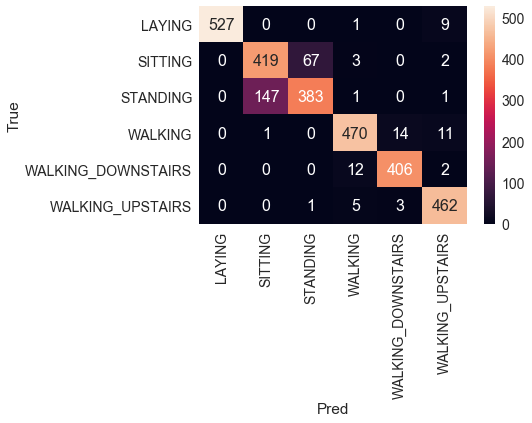

In [36]:
# Confusion Matrix
#print(confusion_matrix(Y_test, model.predict(X_test)))

confusion = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

In [37]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 7s 2ms/step


In [38]:
score

[0.3180937306507453, 0.9049881235154394]

* With a 3 layer architecture we got 90.49% accuracy and a loss of 0.31

## (B) 3 layer with Dropout rate 0.9

In [39]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(LSTM(32)) 
# Adding a dropout layer
model.add(Dropout(0.9))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 129s 18ms/step - loss: 1.4826 - acc: 0.3882 - val_loss: 1.1651 - val_acc: 0.5850
Epoch 2/30
7352/7352 [==============================] - 129s 18ms/step - loss: 1.2229 - acc: 0.4800 - val_loss: 0.9770 - val_acc: 0.5806
Epoch 3/30
7352/7352 [==============================] - 128s 17ms/step - loss: 1.1018 - acc: 0.5033 - val_loss: 0.8310 - val_acc: 0.6060
Epoch 4/30
7352/7352 [==============================] - 126s 17ms/step - loss: 1.0650 - acc: 0.5166 - val_loss: 1.0473 - val_acc: 0.6074
Epoch 5/30
7352/7352 [==============================] - 126s 17ms/step - loss: 1.0466 - acc: 0.5188 - val_loss: 0.7727 - val_acc: 0.6121
Epoch 6/30
7352/7352 [==============================] - 129s 18ms/step - loss: 1.0296 - acc: 0.5165 - val_loss: 0.7627 - val_acc: 0.6105
Epoch 7/30
7352/7352 [==============================] - 128s 17ms/step - loss: 1.0074 - acc: 0.5201 - val_loss: 0.7553 - val_acc: 

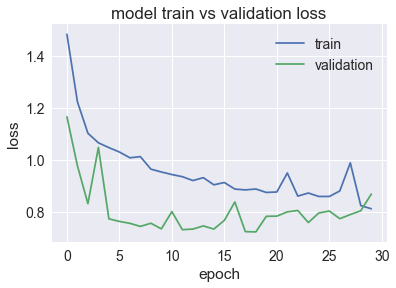

In [41]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

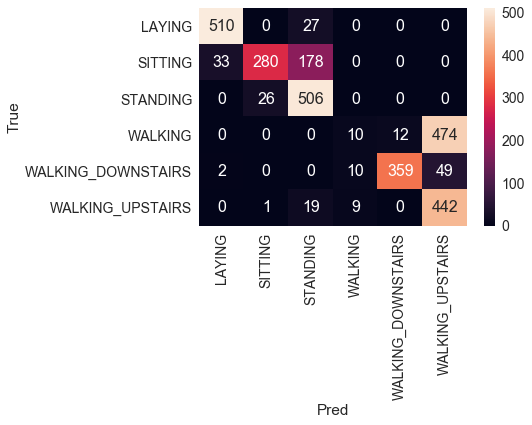

In [42]:
# Confusion Matrix
#print(confusion_matrix(Y_test, model.predict(X_test)))

confusion = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

In [43]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [44]:
score

[0.8678421316043295, 0.7149643705463183]

* With a 3 layer architecture we got 71.49% accuracy and a loss of 0.86

## (C) 3  layer with Dropout rate 0.7

In [45]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(LSTM(64)) 
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 30,598
Trainable params: 30,598
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 61s 8ms/step - loss: 1.1660 - acc: 0.5048 - val_loss: 0.9372 - val_acc: 0.6159
Epoch 2/30
7352/7352 [==============================] - 60s 8ms/step - loss: 0.7870 - acc: 0.6345 - val_loss: 0.8455 - val_acc: 0.6172
Epoch 3/30
7352/7352 [==============================] - 60s 8ms/step - loss: 0.7038 - acc: 0.6598 - val_loss: 0.8476 - val_acc: 0.6145
Epoch 4/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.6714 - acc: 0.6772 - val_loss: 0.8056 - val_acc: 0.6491
Epoch 5/30
7352/7352 [==============================] - 60s 8ms/step - loss: 0.5790 - acc: 0.7550 - val_loss: 0.6294 - val_acc: 0.7489
Epoch 6/30
7352/7352 [==============================] - 59s 8ms/step - loss: 0.4487 - acc: 0.8546 - val_loss: 0.5334 - val_acc: 0.8419
Epoch 7/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.2945 - acc: 0.9094 - val_loss: 0.5563 - val_acc: 0.8554
Epoch 8

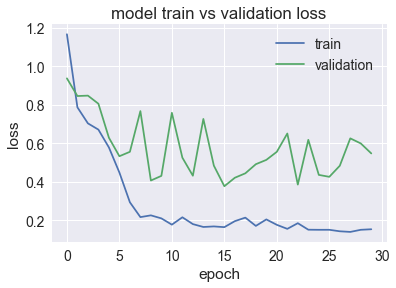

In [47]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

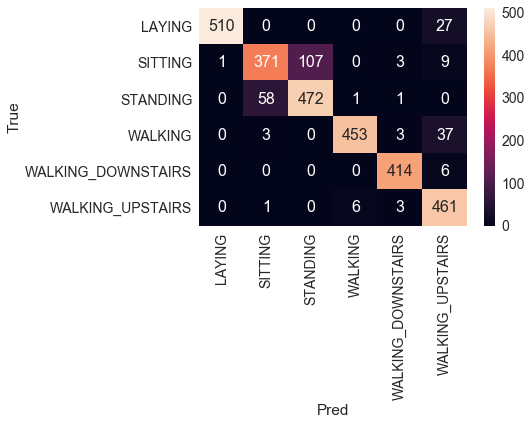

In [48]:
# Confusion Matrix
#print(confusion_matrix(Y_test, model.predict(X_test)))

confusion = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

In [49]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 981us/step


In [50]:
score

[0.5478853281966495, 0.9097387173396675]

* With a 3 layer architecture we got 90.97% accuracy and a loss of 0.54

## conclusions

|layer|n_hidden| dropout rate|accuracy|loss|
|-----|------------|--------|----|
|2 layer|64|0.8|89.68%|0.553|
|2 layer|64|0.7|92.60%|0.427|
|2 layer|32|0.5|90.93%|0.335|
|3 layer|64,32|0.8|90.49%|0.318|
|3 layer|64,32|0.9|71.49%|0.867|
|3 layer|32,64|0.7|90.97%|0.547|


* this data contain 6 classes which has raw data.
* on raw data we applied multiple architecture of LSTM for tuning hyperparameter.
* we applied Dropout for avoid overfit.
* as we see that 3 layer architecture with dropout 0.8 give accuracy of 90.49% and loss of 0.318.
* for 2 layer architecture with dropout 0.7 give accuracy of 92.60% and loss of 0.427.